## Basic setup

In [82]:
from pathlib import Path
import sys, os,  importlib
import pathlib

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # expose only GPU 2 to this process

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root ))
# from src.analysis.interactions import compute_residual_interactions, compute_joint_importance, single_importance, single_importance_chunked
# import pathlib
# from src.explainer.biwinitexplainers import BiWinITExplainer 

import src.analysis.interactions as interactions
import src.explainer.biwinitexplainers as biwinit


from src.explainer.original_winitexplainers import OGWinITExplainer 
from src.dataloader import Mimic, Boiler, SimulatedState
from src.models.base_models import StateClassifier
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict
from typing import Any, List, Tuple, Union
Coords = Union[Tuple[int,int], List[Tuple[int,int]]]


In [83]:
# ---- 3) Helper to reload & re-expose symbols ----
def reload_xai():
    importlib.reload(interactions)
    importlib.reload(biwinit)
    # re-bind the updated callables into the notebook/global namespace
    globals().update({
        "compute_residual_interactions": interactions.compute_residual_interactions,
        "compute_joint_importance":      interactions.compute_joint_importance,
        "single_importance":             interactions.single_importance,
        "single_importance_chunked":     interactions.single_importance_chunked,
        "BiWinITExplainer":              biwinit.BiWinITExplainer,
    })
    print("✅ Reloaded  modules.")

# ---- 4) Initial bind ----
reload_xai()

✅ Reloaded  modules.


In [84]:
def _resolve_path(base_path: pathlib.Path, model_type: str, num_layers: int):
    if model_type == "GRU":
        return base_path / f"gru{num_layers}layer"
    elif model_type == "LSTM":
        return base_path / "lstm"
    elif model_type == "CONV":
        return base_path / "conv"
    else:
        raise Exception("Unknown model type ({})".format(model_type))
        
def _model_name() -> str:
    shortened_args = {
        "bs": 100,
        "hid": 200,
        "drop": 0.5,
    }

    num_layers = 1
    if num_layers is not None and num_layers != 1:
        shortened_args["lay"] = num_layers
    rnn_type = 'gru'
    str_list = ["model"]
    if rnn_type is not None and rnn_type != "gru":
        str_list.append(rnn_type)
    str_list.extend([f"{key}_{value}" for key, value in shortened_args.items()])
    return "_".join(str_list)

def _canon(c: Coords) -> Tuple[Tuple[int,int], ...]:
    """
    Turn either a single (t,d) or a list of them into a tuple of (t,d) tuples.
    """
    if isinstance(c, tuple):
        return (c,)
    elif isinstance(c, list):
        return tuple(c)
    else:
        raise TypeError(f"Expected tuple or list of tuples, got {type(c)}")
    
batch_size = 32
data_seed = 1234
cv_to_use = 0
nondeterministic = False
train_ratio = 0.99
dataset_params = {"batch_size": batch_size,
                  "seed": data_seed, 
                   "cv_to_use": cv_to_use,
                   "deterministic": not nondeterministic,
                    "data_path": "../data/", 
                    "testbs": 32}

mask_strategy = "upper_triangular"
height = 3
xplainer_params = {"mask_strategy": mask_strategy,
                   "height": height
                  }
run_id     = "2025-07-17_state"
# run_id     = "2025-07-15_boiler"


# dataset = Boiler(data_path=dataset_params['data_path'],
#                  batch_size = 32,
#                  testbs = dataset_params['testbs'],
#                  deterministic = dataset_params['deterministic'],
#                  cv_to_use = dataset_params['cv_to_use'],
#                  seed = dataset_params['seed'],
#                  )

dataset = SimulatedState(data_path=dataset_params['data_path'],
                 batch_size = 100,
                 testbs = dataset_params['testbs'],
                 deterministic = dataset_params['deterministic'],
                 cv_to_use = dataset_params['cv_to_use'],
                 seed = dataset_params['seed'],
                 )

dataset.load_data(train_ratio=train_ratio)

cv = 0
ckptpath = "../ckpt/"   
model_type = 'GRU'
base_ckpt_path = pathlib.Path(ckptpath)
num_layers = 1
ckpt_path = _resolve_path(base_ckpt_path, model_type, num_layers)
device = 'cpu'



# 0) Prepare your model
model = StateClassifier(
                feature_size=dataset.feature_size,
                num_states=dataset.num_classes,
                hidden_size=200,
                device=device,
                rnn=model_type,
                num_layers=num_layers,
                dropout=0.5,
            )


# 1) Prepare your explainer and data
explainer = BiWinITExplainer(
                    device,
                    dataset.feature_size,
                    dataset.get_name(),
                    path= ckpt_path / dataset.get_name() / str(cv),
                    train_loader=dataset.train_loaders[cv],  # for CF generaton if required, NOT for training 
                    other_args = xplainer_params
                )   


model_path = ckpt_path / dataset.get_name()
_model_file_name = model_path / f"{_model_name()}_{cv}.pt"

# ckpt_path = "path/to/your/checkpoint.pt"   # or .pth, .tar, etc.
ckpt = torch.load(str(_model_file_name), map_location=torch.device(device))
state_dict = ckpt.get("state_dict", ckpt)
model.load_state_dict(state_dict)
model.to(device)
model.eval()
explainer.set_model(model,
                    set_eval=True)




In [85]:
# how many batches to concat
num_batches = 3# len(dataset.test_loader)

xs = []
ys = []
it = iter(dataset.test_loader)

for _ in range(num_batches):
    x_batch, y_batch = next(it)   # x_batch: [32, 3, 100], y_batch: [32]
    xs.append(x_batch)
    ys.append(y_batch)

# now concatenate along the batch dimension
X_test = torch.cat(xs, dim=0).to(device)   # [32*10, 3, 100] == [320, 3, 100]
Y_test = torch.cat(ys, dim=0)              # [320]

print(f"✔️  Fetched {num_batches} batches:")
print(f"   X_test.shape = {X_test.shape}, Y_test.shape = {Y_test.shape}")



pixels     = [(0,10), (1,10), (2,10), (0,19), (1,19), (2,19),
              (0,13), (1,13), (2,13), 
            #   (0,39), (1,39), (2,39)
            ]  
# pixels     = [(10,0), (10,1), (10,2), (19,0), (19,1), (19,2)]  
save_root  = Path("../outputs")


✔️  Fetched 3 batches:
   X_test.shape = torch.Size([96, 3, 100]), Y_test.shape = torch.Size([96, 100])


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# 3) sampling strategy function
def get_pair_strategy(
    source_pixels: List[Tuple[int,int]],
    T: int,
    D: int,
    tau: int,
    strategy: str = "same_d"
) -> List[Tuple[Tuple[int,int], Tuple[int,int]]]:
    output_pairs = []
    for (t, d) in source_pixels:

        if strategy == "same_d":
            t2 = t + tau
            d2 = d
            if not (0 <= t2 < T):
                t2 = T-1
            output_pairs.append(((t,d), (t2, d2)))

        elif strategy == "next_d":
            t2 = t + tau
            d2 = min(d + 1, D - 1)
            output_pairs.append(((t,d), (t2, d2)))

        elif strategy == "vertical_strip":
            t2 = t + tau
            target_blob = []

            for dd in range(D):
                target_blob.append((t2,dd))
            output_pairs.append(((t,d), target_blob))

        else:
            raise ValueError(f"Unknown strategy '{strategy}'")
    
    return output_pairs

# 4) illustrate_pair
def illustrate_pair(pair: Tuple[Tuple[int,int], Tuple[int,int]], T: int, D: int):
    grid = np.ones((T, D, 3)) * 0.8
    p, q = pair
    grid[p[0], p[1]] = [1.0, 0.5, 0.0]
    grid[q[0], q[1]] = [1.0, 0.5, 0.0]
    plt.figure(figsize=(4, 4))
    plt.imshow(grid, aspect='auto')
    plt.title(f"{p} → {q}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [87]:

B, D, T = X_test.shape

source_pixels     = [(0,0), (1,0), (2,0), 
                    (0,1), (1,1), (2,1),
                    (0,2), (1,2), (2,2), 
                    ]  
save_root  = Path("../outputs")
run_id     = "2025-07-17_state"

out_dir = save_root / run_id / "interactions"
# 8) line plots of mean ΔI vs tau for each strategy
tau_values = list(range(3, 97, 3))


## No Window Calculation

### strategy: same row: all calculation

In [70]:
out_dir = save_root / run_id / "interactions"


In [71]:

print('source_pixels', source_pixels)
num_pairs = len(source_pixels)

pair_strategies =  ["same_d"]#, "next_d"]

for strategy in pair_strategies:
    delta_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)
    all_Ip_flat_taus = np.zeros((len(tau_values), 2*num_pairs, B), dtype=float)
    all_Ipq_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)

    master_Ip = {} #defaultdict(list)

    for ti, tau in enumerate(tau_values):
        output_pairs = get_pair_strategy(source_pixels, T, D, tau, strategy=strategy)
        print(output_pairs)

        all_Ip, all_Ipq, delta_dict = compute_residual_interactions(
                    explainer=explainer,
                    X=X_test,
                    pairs=output_pairs,
                    save_dir=save_root,
                    run_id=run_id
                )
        # merge single-importance dict into master_Ip
        for pix, scores in all_Ip.items():
            # scores is a 1D array of shape (B,)
            master_Ip[pix] = scores
              
        num_pixels = 2 * len(source_pixels)
        
        delta_flat = np.stack([delta_dict[pair] for pair in output_pairs], axis=0)
        delta_flat_taus[ti, :, :] = delta_flat

        # all_Ip_flat = np.stack([all_Ip[p] for p in all_Ip.keys()], axis=0)
        # all_Ip_flat_taus[ti, :, :] = all_Ip_flat

        all_Ipq_flat = np.stack([all_Ipq[pq] for pq in all_Ipq.keys()], axis=0)
        all_Ipq_flat_taus[ti, :, :] = all_Ipq_flat

    
    all_Ip_flat_taus = np.full((T, D, B), np.nan, dtype=float)
    for (t, d), scores in master_Ip.items():
        # scores must be shape (B,)
        all_Ip_flat_taus[t, d, :] = scores


np.save(out_dir / f"delta_flat_taus.npy", delta_flat_taus)
np.save(out_dir / f"all_Ip_flat_taus.npy", all_Ip_flat_taus)
np.save(out_dir / f"all_Ipq_flat_taus.npy", all_Ipq_flat_taus)

    





source_pixels [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]
[((0, 0), (3, 0)), ((1, 0), (4, 0)), ((2, 0), (5, 0)), ((0, 1), (3, 1)), ((1, 1), (4, 1)), ((2, 1), (5, 1)), ((0, 2), (3, 2)), ((1, 2), (4, 2)), ((2, 2), (5, 2))]


TypeError: single_importance() missing 1 required positional argument: 'out_dir'

In [ ]:
# delta_flat_taus = np.load(out_dir / f"delta_flat_taus.npy")
all_Ip_flat_taus = np.load(out_dir / f"all_Ip_flat_taus.npy")
all_Ipq_flat_taus = np.load(out_dir / f"all_Ipq_flat_taus.npy")

In [ ]:
print(all_Ip_flat_taus.shape)
print(delta_flat_taus.shape)
print(all_Ipq_flat_taus.shape)

### residue plotting

In [ ]:
delta_flat_taus.shape # tau, n, B
matrix = np.mean(delta_flat_taus, axis =2)          
pair_labels = [f"{pixel}" for pixel in source_pixels]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math

# --- Assumes delta_flat_taus, tau_values, output_pairs are defined ---
# delta_flat_taus: shape (T_, P_, B)

# 1) Compute statistics
mean_taus = delta_flat_taus.mean(axis=2)  # (T_, P_)
std_taus  = delta_flat_taus.std(axis=2)   # (T_, P_)
T_, P_ = mean_taus.shape

# 2) Determine common axis limits
y_min = (mean_taus - std_taus).min()
y_max = (mean_taus + std_taus).max()
x_min, x_max = min(tau_values), max(tau_values)

# 3) Grid dimensions
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

# 4) Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), 
                         sharex=True, sharey=True)
axes = axes.flatten()

cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax = axes[j]
    color = cmap(j % cmap.N)
    mu  = mean_taus[:, j]
    sig = std_taus[:, j]/2

    ax.plot(tau_values, mu, 
            # marker='o',
            color=color, linewidth=1.2)
    ax.fill_between(tau_values, mu - sig, mu + sig, color=color, alpha=0.2)
    ax.set_title(pair_labels[j], fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(alpha=0.3, linestyle='--')

# Turn off any extra axes
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])

# Labels on edge plots
for ax in axes[:]:
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("residual", fontsize=10)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("τ", fontsize=10)

plt.tight_layout()
plt.show()


### Joint interaction plotting

In [ ]:
all_Ipq_flat_taus.shape

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math

# --- Assumes delta_flat_taus, tau_values, output_pairs are defined ---
# delta_flat_taus: shape (T_, P_, B)

# 1) Compute statistics
mean_taus = all_Ipq_flat_taus.mean(axis=2)  # (T_, P_)
std_taus  = all_Ipq_flat_taus.std(axis=2)   # (T_, P_)
T_, P_ = mean_taus.shape

# 2) Determine common axis limits
y_min = (mean_taus - std_taus).min()
y_max = (mean_taus + std_taus).max()
x_min, x_max = min(tau_values), max(tau_values)

# 3) Grid dimensions
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

# 4) Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), 
                         sharex=True, sharey=True)
axes = axes.flatten()

cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax = axes[j]
    color = cmap(j % cmap.N)
    mu  = mean_taus[:, j]
    sig = std_taus[:, j]/2

    ax.plot(tau_values, mu, 
            # marker='o',
            color=color, linewidth=1.2)
    ax.fill_between(tau_values, mu - sig, mu + sig, color=color, alpha=0.2)
    ax.set_title('source cell: ' + pair_labels[j], fontsize=10)
    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(y_min, y_max)
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_xlabel("τ", fontsize=10)

# Turn off any extra axes
# for k in range(P_, rows*cols):
#     fig.delaxes(axes[k])

# Labels on edge plots
for ax in axes[:]:
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("joint importance score", fontsize=10)
    # if ax.get_subplotspec().is_last_row():

plt.tight_layout()
plt.show()


### Raw importance plotting 

/tmp/ipykernel_208306/881157917.py:6: RuntimeWarning: Mean of empty slice
  mean_heat = np.nanmean(all_Ip_flat_taus, axis=2)  # shape (100, 3)


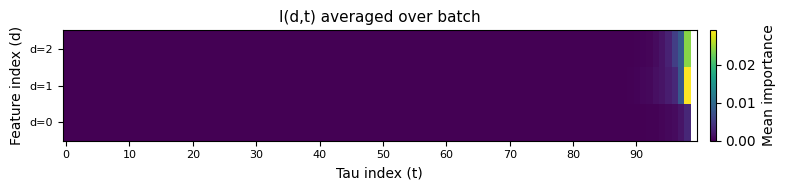

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute mean as before
# all_Ip_flat_taus.shape == (T=100, D=3, B)
mean_heat = np.nanmean(all_Ip_flat_taus, axis=2)  # shape (100, 3)

# 2) Transpose so that features (D=3) are on the y axis
heat_T = mean_heat.T  # now shape (3, 100)

# 3) Plot with a short height (3 strips)
plt.figure(figsize=(8, 2))               # wide and short
im = plt.imshow(
    heat_T,
    origin='lower',
    aspect='auto',
    cmap='viridis',
    interpolation='nearest'
)

# 4) Colorbar
cbar = plt.colorbar(im, fraction=0.04, pad=0.02)
cbar.set_label("Mean importance", fontsize=10)

# 5) Discrete ticks
# x-axis: time 0..99
plt.xticks(np.arange(0, mean_heat.shape[0], 10),  # every 10 for readability
           np.arange(0, mean_heat.shape[0], 10),
           fontsize=8)
# y-axis: features 0,1,2
plt.yticks([0,1,2], ["d=0","d=1","d=2"], fontsize=8)

plt.xlabel("Tau index (t)", fontsize=10)
plt.ylabel("Feature index (d)", fontsize=10)
plt.title("I(d,t) averaged over batch", fontsize=11)

plt.tight_layout()
plt.show()


### strategy: strips, blobs, patches : all calculation

#### Vertical strip

In [ ]:

print('source_pixels', source_pixels)
num_pairs = len(source_pixels)
out_dir = save_root / run_id / "interactions_strip"
pair_strategies =  ["vertical_strip"]#, "next_d"]
tau_values = list(range(3, 97, 3))






for strategy in pair_strategies:
    delta_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)
    all_Ip_flat_taus = np.zeros((len(tau_values), 2*num_pairs, B), dtype=float)
    all_Ipq_flat_taus = np.zeros((len(tau_values), num_pairs, B), dtype=float)

    master_Ip = {} #defaultdict(list)

    for ti, tau in enumerate(tau_values):
        output_pairs = get_pair_strategy(source_pixels, T, D, tau, strategy=strategy)
        print(output_pairs)

        all_Ipq = compute_joint_importance(output_pairs, X_test, explainer)
        print('all_Ipq.keys():', all_Ipq.keys())

        # 2) build a list of *canonicalized* keys in the same order as output_pairs
        canonical_keys = []
        for p, q in output_pairs:
            src_key = _canon(p)   # ALWAYS a tuple of tuples
            tgt_key = _canon(q)
            canonical_keys.append((src_key, tgt_key))
        
        print('canonical_keys.keys():', canonical_keys)

        # 3) stack in that exact order
        all_Ipq_flat = np.stack([all_Ipq[key] for key in canonical_keys], axis=0)
        
        # 4) assign into the big tensor
        all_Ipq_flat_taus[ti, :, :, :] = all_Ipq_flat



# np.save(out_dir / f"delta_flat_taus.npy", delta_flat_taus)
# np.save(out_dir / f"all_Ip_flat_taus.npy", all_Ip_flat_taus)
np.save(out_dir / f"all_Ipq_flat_taus.npy", all_Ipq_flat_taus)







In [ ]:
all_Ipq_flat_taus.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: shape (T_, P_, B)
# source_pixels:      list of P_ pixel coords
# tau_values:         list of T_ τ values

# 1) Compute mean & std over the batch axis
mean_Ipq = all_Ipq_flat_taus.mean(axis=2)  # (T_, P_)
std_Ipq  = all_Ipq_flat_taus.std(axis=2)   # (T_, P_)
T_, P_   = mean_Ipq.shape

# 2) Grid dimensions
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

# 3) Set up figure & colormap
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                         sharex=True, sharey=True)
axes = axes.flatten()
cmap = cm.get_cmap('tab10')

# 4) Global y-limits for consistency
ymin = (mean_Ipq - std_Ipq).min()
ymax = (mean_Ipq + std_Ipq).max()

# 5) Plot each pixel’s curve + band
for j in range(P_):
    ax = axes[j]
    color = cmap(j % cmap.N)
    mu  = mean_Ipq[:, j]
    sig = std_Ipq[:, j]

    ax.plot(tau_values, mu,
            linewidth=1.5,
            color=color, label=f"{source_pixels[j]}")
    ax.fill_between(tau_values,
                    mu - sig,
                    mu + sig,
                    color=color, alpha=0.2)

    ax.set_title(f"source pixels: {source_pixels[j]}", fontsize=9)
    ax.set_xlim(min(tau_values), max(tau_values))
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3, linestyle='--')

    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel(r"$\tau$", fontsize=10)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Joint importance", fontsize=10)

# 6) Remove unused axes
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])

# 7) Legend (optional, or drop if too crowded)
# fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0))

plt.tight_layout()
plt.show()


## Windowed imp score calculations

### strategy: strips, blobs, patches : all calculation

In [76]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print('source_pixels', source_pixels)
num_pairs = len(source_pixels)
out_dir = save_root / run_id / "interactions_window_strip"
pair_strategies =  ["vertical_strip"]#, "next_d"]
tau_values = list(range(3, 97, 3))

source_pixels [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]


#### Joint importance caclulation

In [ ]:







for strategy in pair_strategies:
    delta_flat_taus = np.zeros((len(tau_values), num_pairs, B, explainer.window_size), dtype=float)
    # all_Ip_flat_taus = np.zeros((len(tau_values), 2*num_pairs, B, ), dtype=float)
    all_Ipq_flat_taus = np.zeros((len(tau_values), num_pairs, B, explainer.window_size), dtype=float)
    

  
    for ti, tau in enumerate(tau_values):
        output_pairs = get_pair_strategy(source_pixels, T, D, tau, strategy=strategy)
        print(output_pairs)

        # 1) Prepping Single pixel importance
        # all_pixels = all_pixels + list(set({pix for src, tgts in output_pairs for pix in ((src,) + tuple(tgts))}))
        # all_pixels = list(set(all_pixels))
        # print('all_pixels:', all_pixels)
        # print(len(all_pixels))

        

        
        # 2) Joint blob-blob importance
        all_Ipq = compute_joint_importance(output_pairs, X_test, explainer)
        print('all_Ipq.keys():', all_Ipq.keys())

        # 2.1) build a list of *canonicalized* keys in the same order as output_pairs
        canonical_keys = []
        for p, q in output_pairs:
            src_key = _canon(p)   # ALWAYS a tuple of tuples
            tgt_key = _canon(q)
            canonical_keys.append((src_key, tgt_key))
        
        print('canonical_keys.keys():', canonical_keys)

        # 2.2) stack in that exact order
        all_Ipq_flat = np.stack([all_Ipq[key] for key in canonical_keys], axis=0)
        
        # 2.3) assign into the big tensor
        all_Ipq_flat_taus[ti, :, :, :] = all_Ipq_flat



# np.save(out_dir / f"delta_flat_taus.npy", delta_flat_taus)
np.save(out_dir / f"all_Ipq_flat_taus.npy", all_Ipq_flat_taus)







[((0, 0), [(3, 0), (3, 1), (3, 2)]), ((1, 0), [(4, 0), (4, 1), (4, 2)]), ((2, 0), [(5, 0), (5, 1), (5, 2)]), ((0, 1), [(3, 0), (3, 1), (3, 2)]), ((1, 1), [(4, 0), (4, 1), (4, 2)]), ((2, 1), [(5, 0), (5, 1), (5, 2)]), ((0, 2), [(3, 0), (3, 1), (3, 2)]), ((1, 2), [(4, 0), (4, 1), (4, 2)]), ((2, 2), [(5, 0), (5, 1), (5, 2)])]


NameError: name 'all_pixels' is not defined

In [115]:
all_Ipq_flat_taus = np.load(out_dir / f"all_Ipq_flat_taus.npy")
all_Ipq_flat_taus.shape

(32, 9, 96, 10)

In [ ]:
del all_Ipq
del all_Ipq_flat
del all_Ipq_flat_taus
del canonical_keys   # anything you no longer need
torch.cuda.empty_cache()   

NameError: name 'all_Ipq' is not defined

In [ ]:
import os, torch
print("PID:", os.getpid())
print("current_device:", torch.cuda.current_device())
print("device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.cuda.memory_summary(torch.cuda.current_device()))

PID: 216999
current_device: 0
device name: NVIDIA GeForce RTX 3090
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B  

#### Single importance calculation

In [78]:
B

96

In [88]:
device = 'cpu'
# torch.cuda.set_device(1)

explainer.base_model = explainer.base_model.to("cpu")
X_test = X_test.cpu()

# torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('source_pixels', source_pixels)
num_pairs = len(source_pixels)
out_dir = save_root / run_id / "interactions_window_strip"
pair_strategies =  ["vertical_strip"]#, "next_d"]
tau_values = list(range(3, 97, 3))

for strategy in pair_strategies:
    all_pixels = []
    master_Ip = {} #defaultdict(list)
    all_pixels = [(t, d) for t in range(T) for d in range(D)]


    # 1.2 Calculate single importance
    all_Ip = single_importance(explainer, X_test, all_pixels, out_dir)
    # all_Ip = single_importance_chunked(explainer, X_test, all_pixels,
    #                                chunk_pix=32, chunk_batch=64,
    #                                device="cuda")  # pick a GPU
    print(len(all_Ip))


    all_Ip_flat_taus = np.zeros((T, D, B, explainer.window_size), dtype=float)
   
        
    for (t, d), scores in all_Ip.items():
        # stack and move to CPU/NumPy
        # print('opening the all_Ip now, len(scores) | scores[0].shape|', len(scores), '|', scores[0].shape)
        # print('(t,d) in all_Ip.keys():', t, d)

        stack_list = []
        for s in scores:
            if torch.is_tensor(s):
                ss = s.detach().cpu().view(B)          # ensure 1-D, length B
            else:
                # skip OR fill with zeros; pick one:
                # continue                       # <-- skip this element entirely
                ss = torch.zeros(B)                # <-- or keep slot, just zeros
            stack_list.append(ss)

        if len(stack_list) == 0:           # nothing valid? make an empty (B,0)
            arr = np.zeros((B, 0), dtype=np.float32)
        else:
            arr = torch.stack(stack_list, dim=1).numpy()   # (B, W_effective)
        # print('ar.shaper:', arr.shape)
        all_Ip_flat_taus[t, d, :, :] = arr

np.save(out_dir / f"all_Ip_flat_taus.npy", all_Ip_flat_taus)


source_pixels [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (2, 2)]


300


In [89]:
all_Ip_flat_taus.shape

(100, 3, 96, 10)

In [81]:
# print(all_Ip[(55,2)][0])
# print(all_Ip[(55,1)][0])

# print(all_Ip[(55,2)][0].detach().cpu() - all_Ip[(55,1)][0].detach().cpu())
print(len(all_Ip[(55,2)]))
print(len(all_Ip[(55,1)]))
print(all_Ip[(55,2)][0].shape)
print(all_Ip[(55,1)][0].shape)
print(all_Ip[(55,1)][2].detach().cpu() - all_Ip[(55,2)].detach().cpu())


10
10
torch.Size([64])
torch.Size([64])


AttributeError: 'list' object has no attribute 'detach'

#### Joint interaction plotting

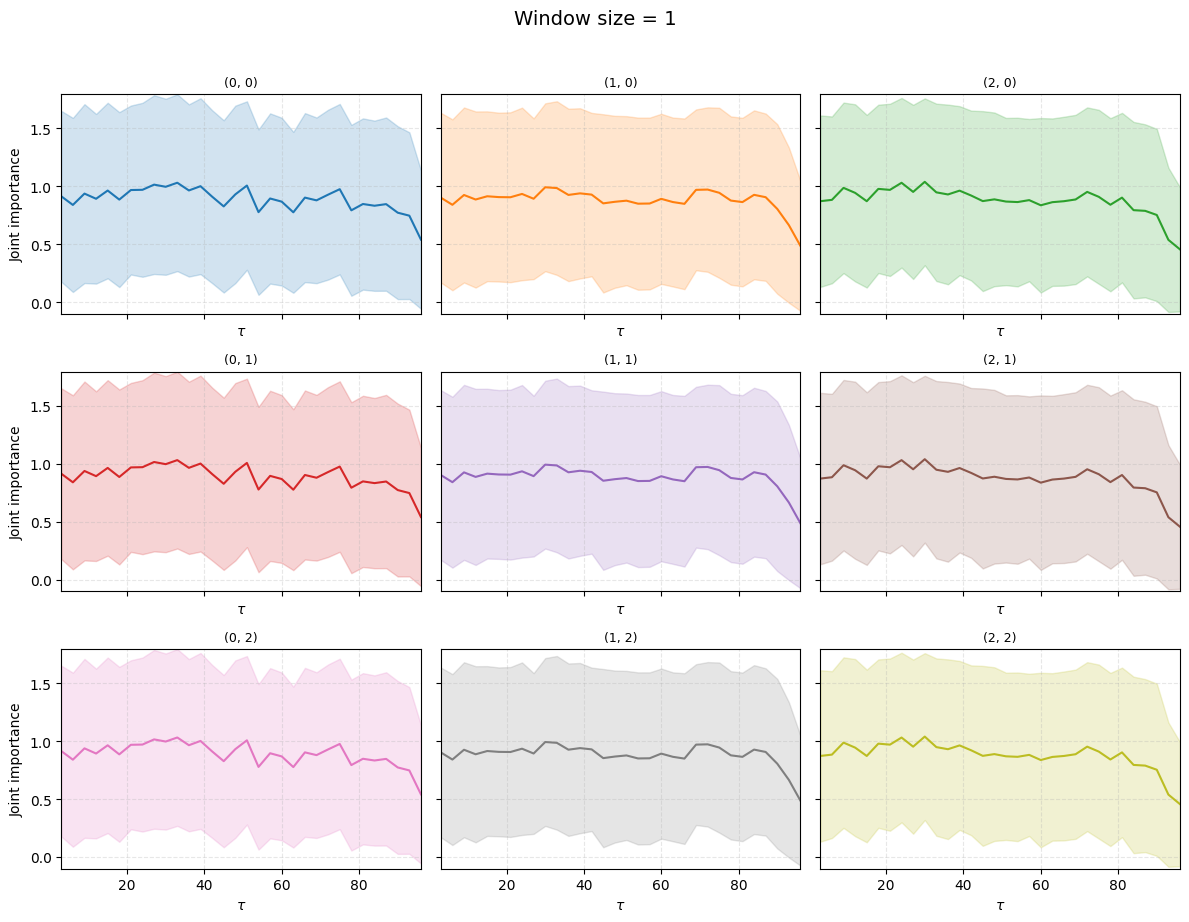

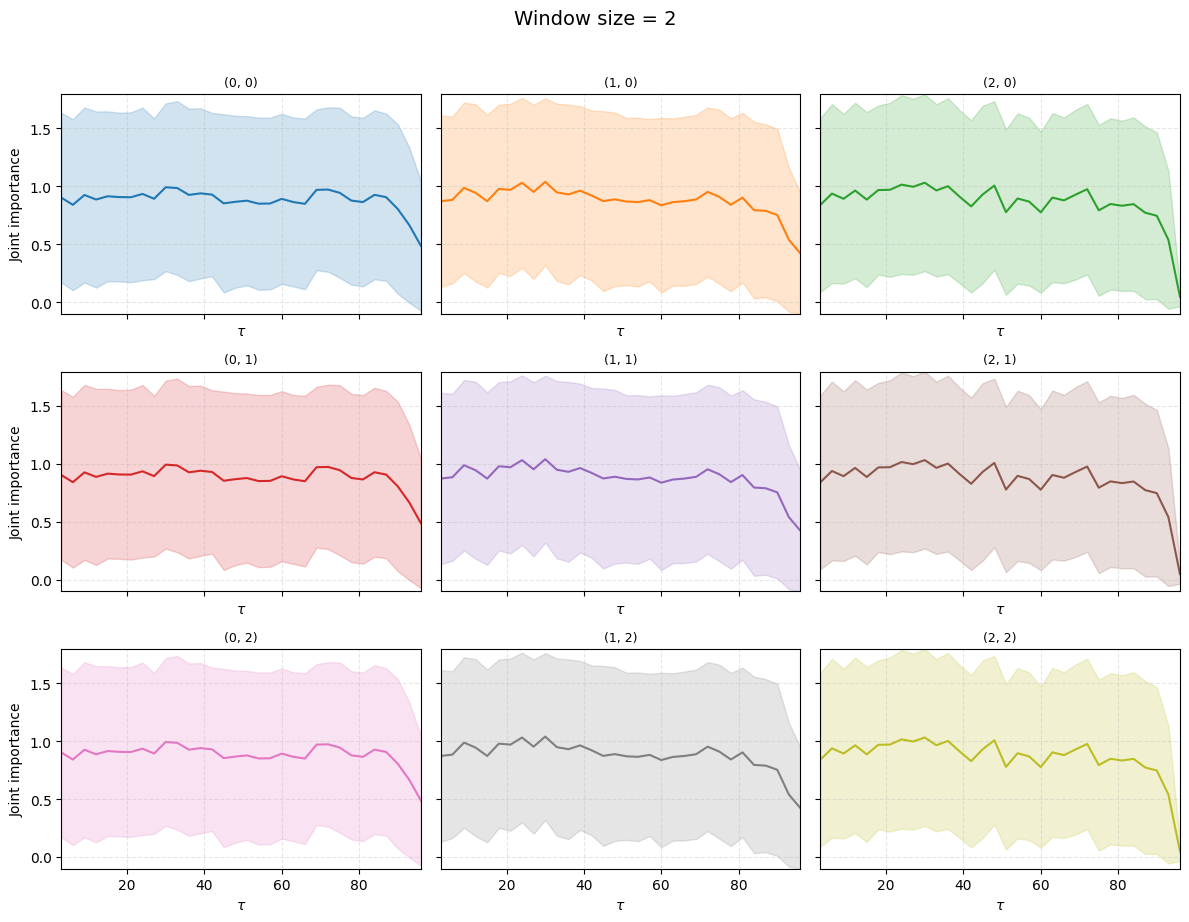

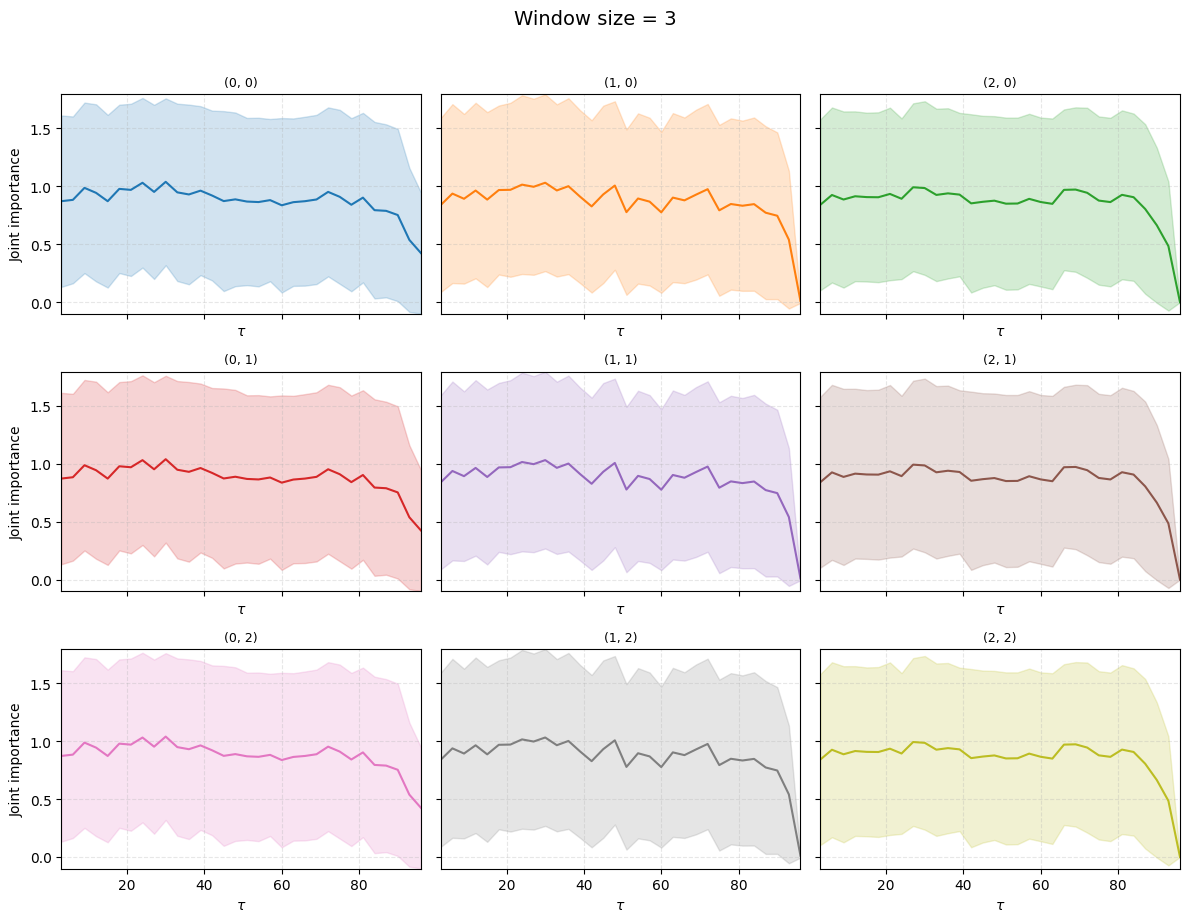

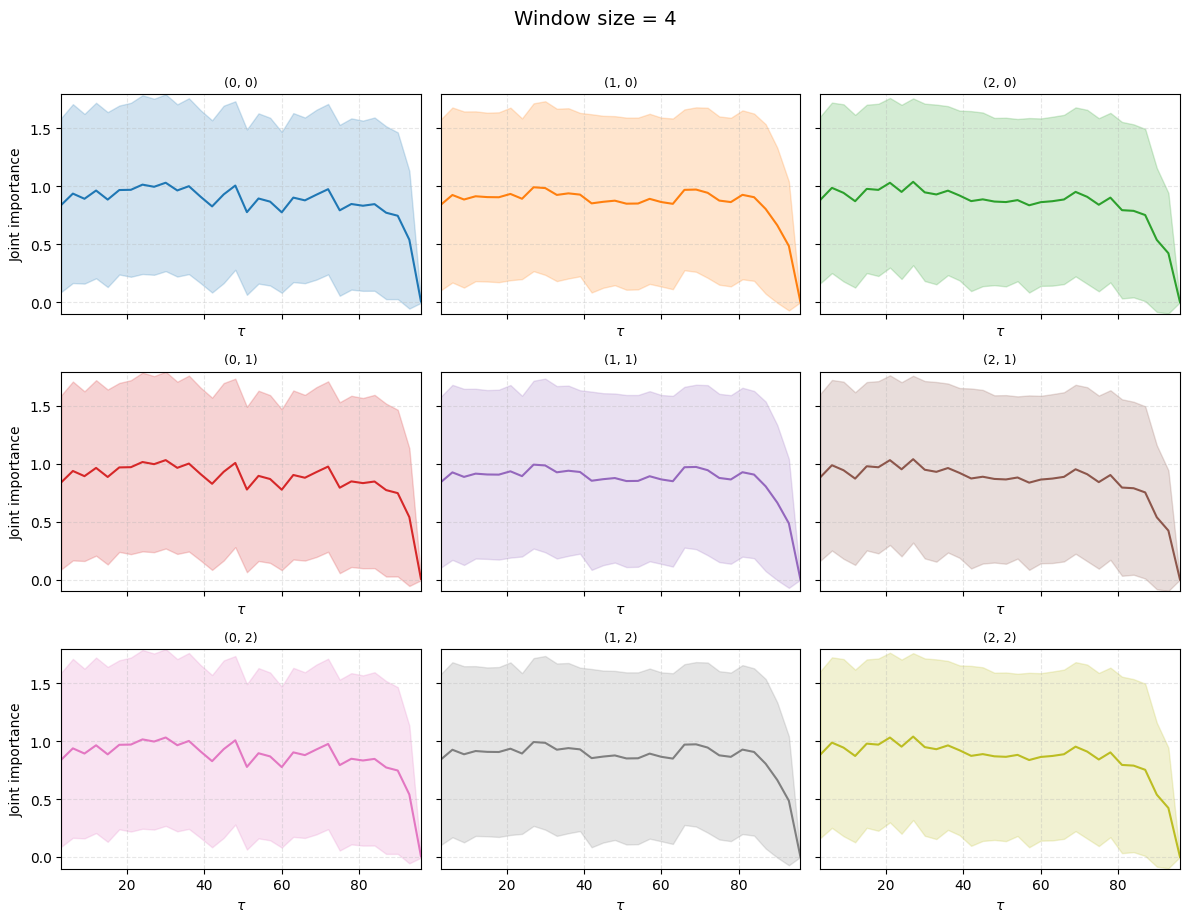

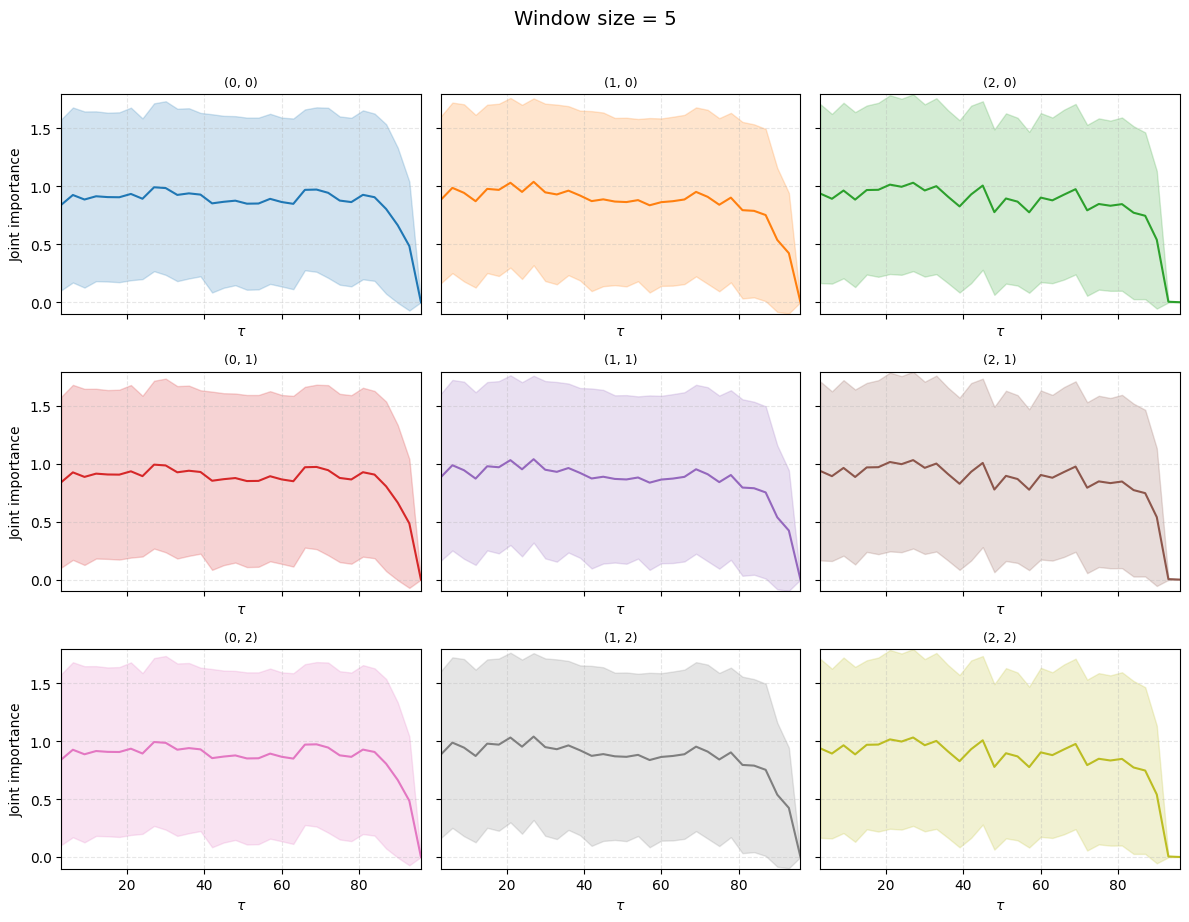

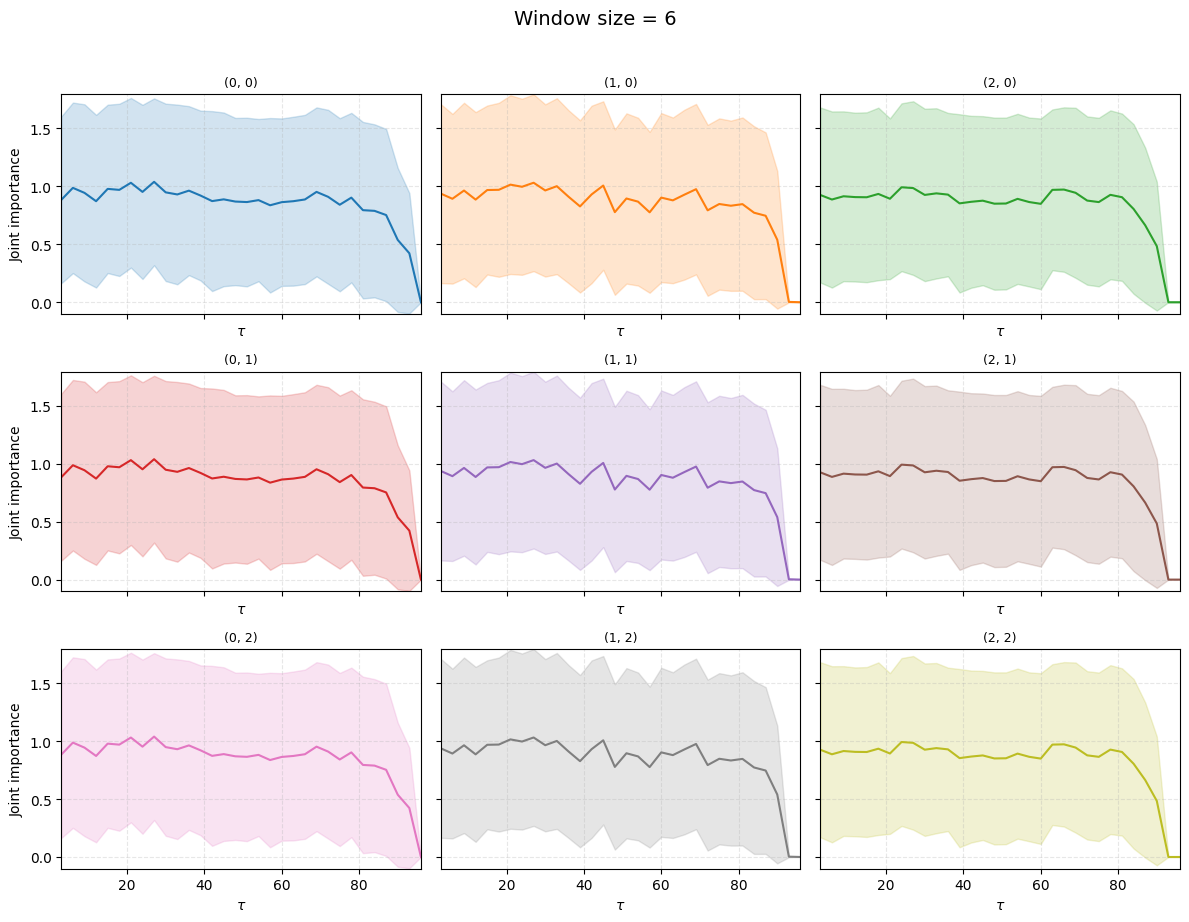

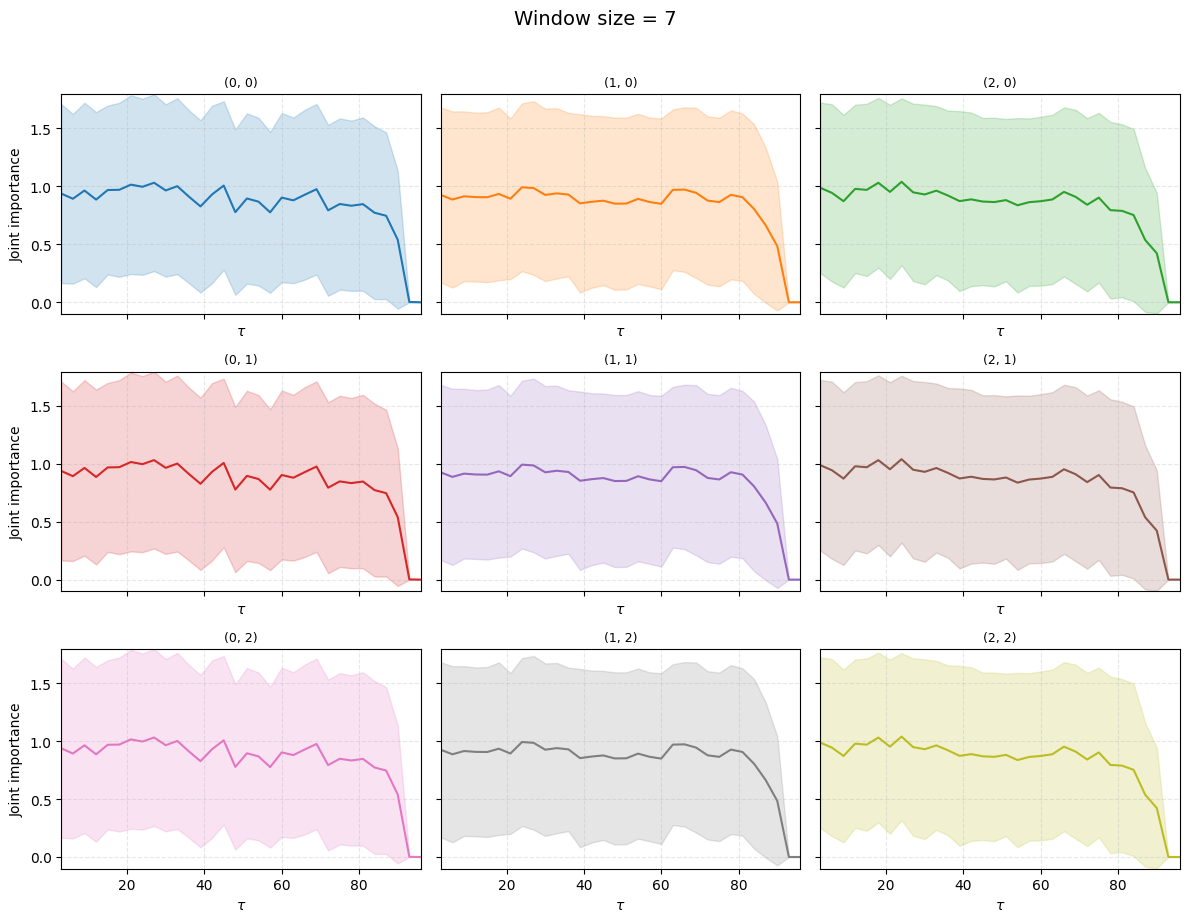

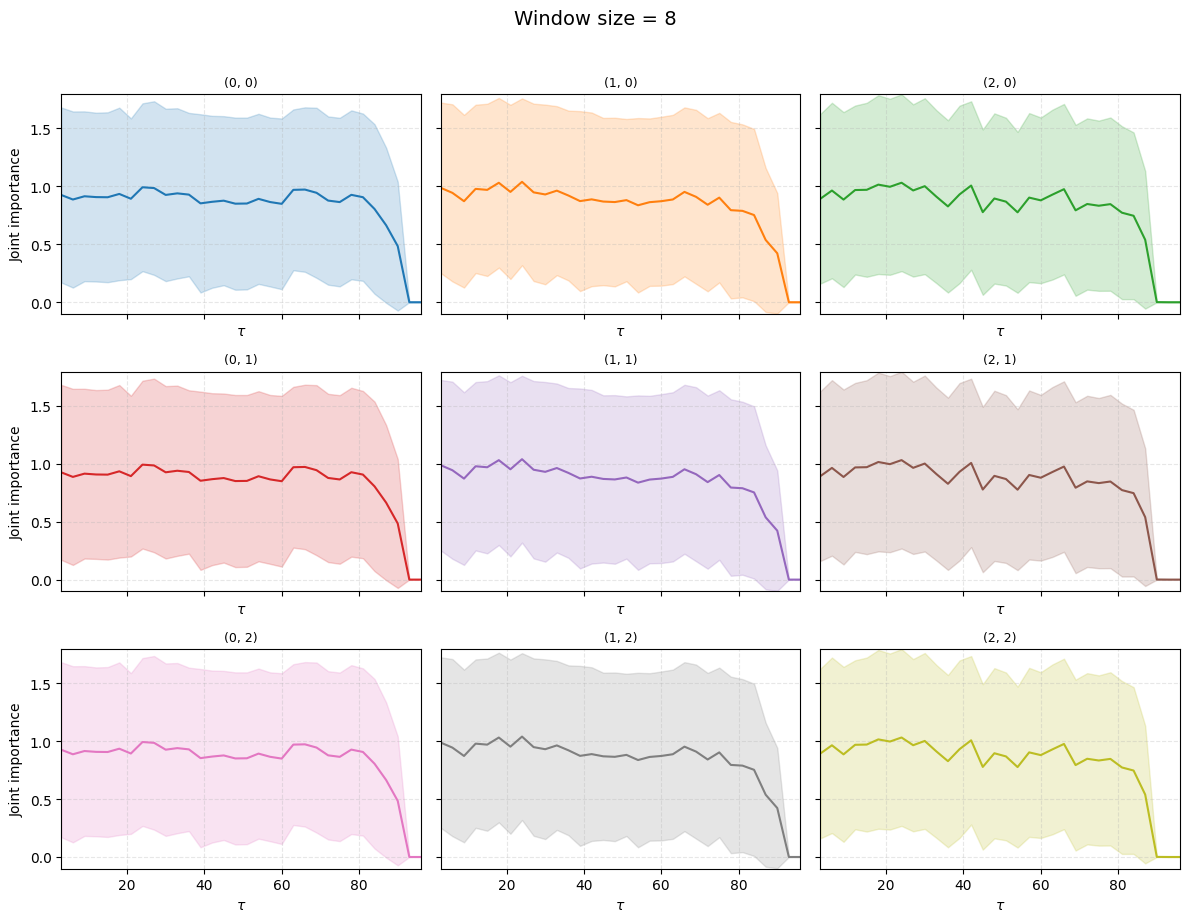

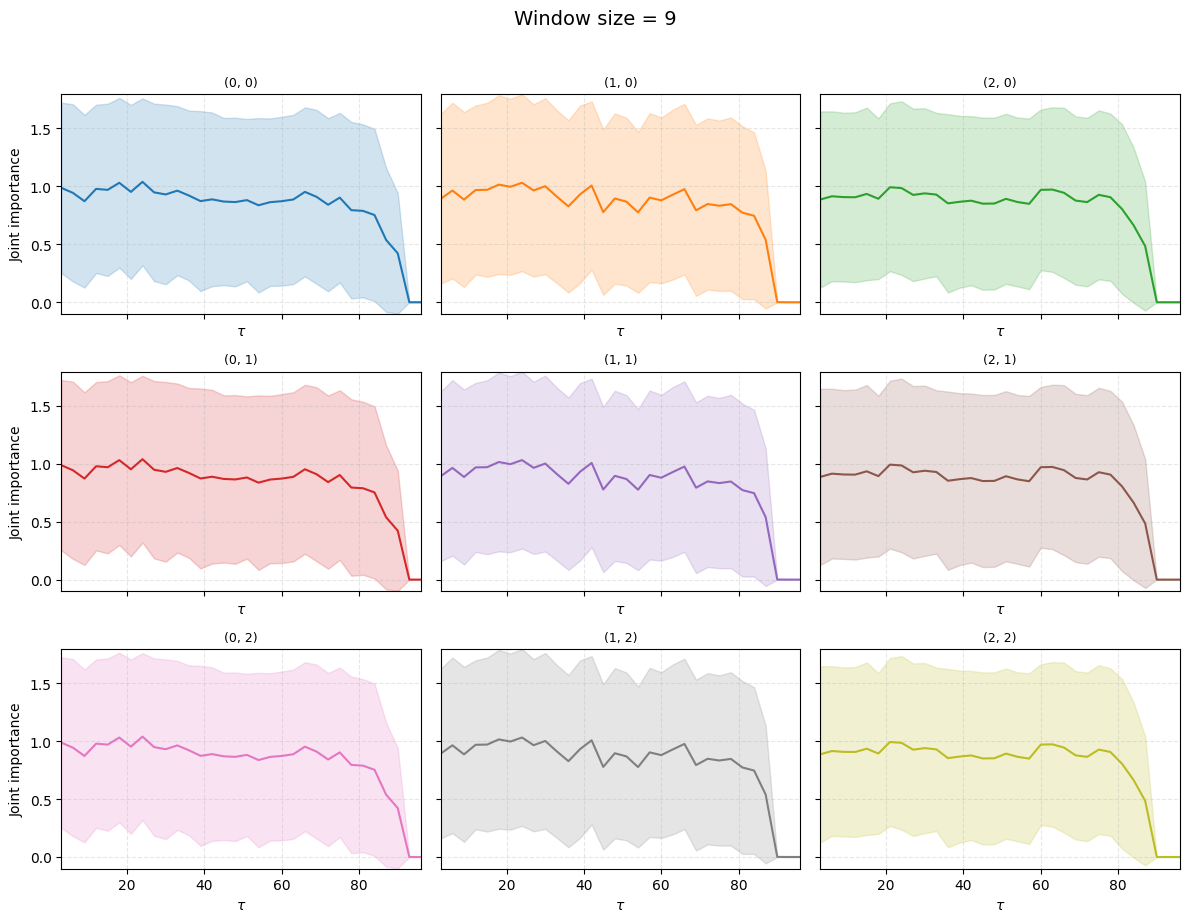

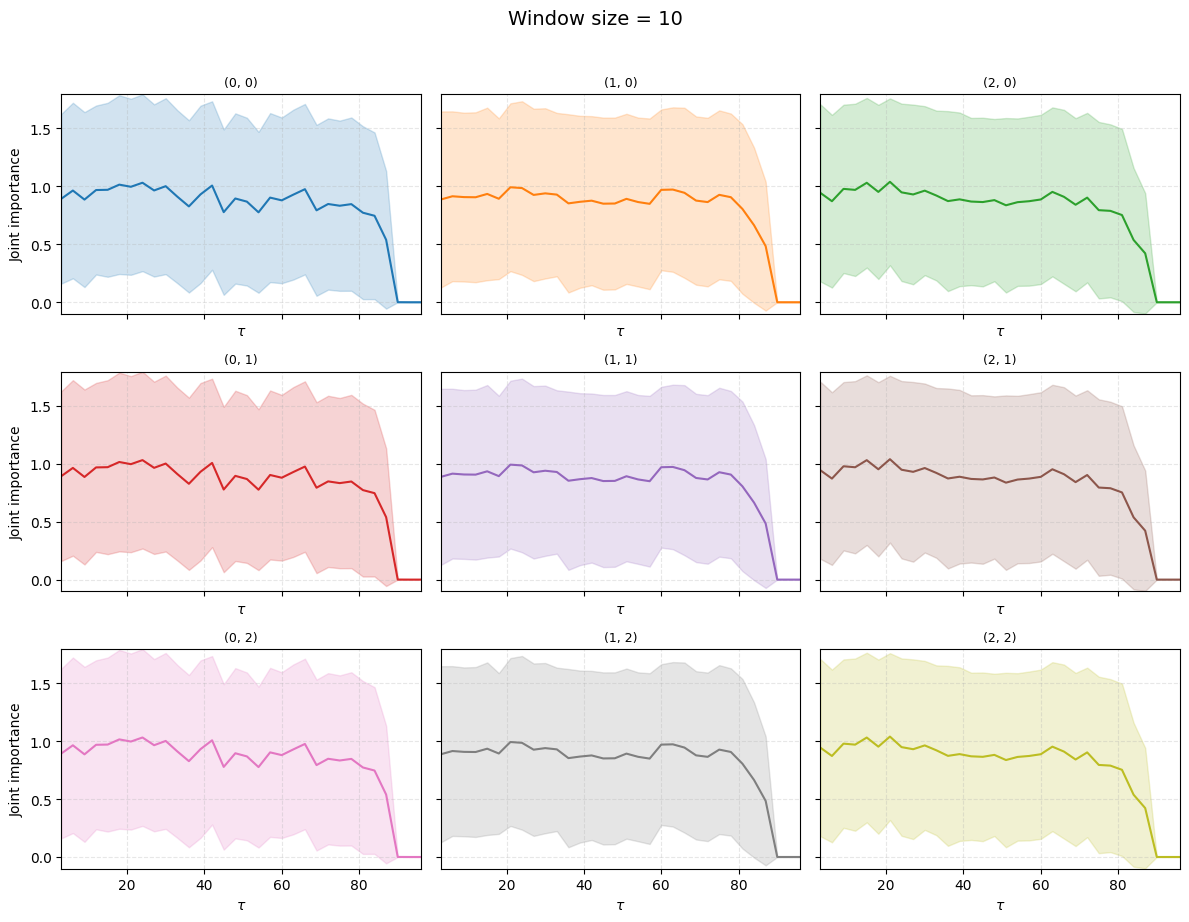

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: (T_, P_, B, W)
T_, P_, B, W = all_Ipq_flat_taus.shape
tau_vals = tau_values            # alias
src_pix  = source_pixels         # length P_

# mean & std over batch
mu  = all_Ipq_flat_taus.mean(axis=2)   # (T_, P_, W)
sig = all_Ipq_flat_taus.std(axis=2)    # (T_, P_, W)

# global y-lims across ALL windows (so plots are comparable)
ymin = (mu - sig).min()
ymax = (mu + sig).max()

# grid size for subplots
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))
cmap = cm.get_cmap('tab10')

def plot_window(w_idx):
    """One full grid for the w-th window."""
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                             sharex=True, sharey=True)
    axes = axes.ravel()

    for j in range(P_):
        ax   = axes[j]
        col  = cmap(j % cmap.N)
        m_j  = mu[:, j, w_idx]
        s_j  = sig[:, j, w_idx]

        ax.plot(tau_vals, m_j, color=col, linewidth=1.5)
        ax.fill_between(tau_vals, m_j - s_j, m_j + s_j,
                        color=col, alpha=0.2)

        ax.set_title(f"{src_pix[j]}", fontsize=9)
        ax.set_xlim(min(tau_vals), max(tau_vals))
        ax.set_ylim(ymin, ymax)
        ax.grid(alpha=0.3, linestyle='--')

        # if ax.get_subplotspec().is_last_row():
        ax.set_xlabel(r"$\tau$", fontsize=10)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Joint importance", fontsize=10)

    # remove unused axes
    # for k in range(P_, rows*cols):
    #     fig.delaxes(axes[k])

    fig.suptitle(f"Window size = {w_idx+1}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    # Or save: fig.savefig(f"joint_imp_w{w_idx}.png", dpi=300, bbox_inches='tight')

# ---- repeat for all W ----
for w in range(W):
    plot_window(w)


#### Joint importance: agg over W

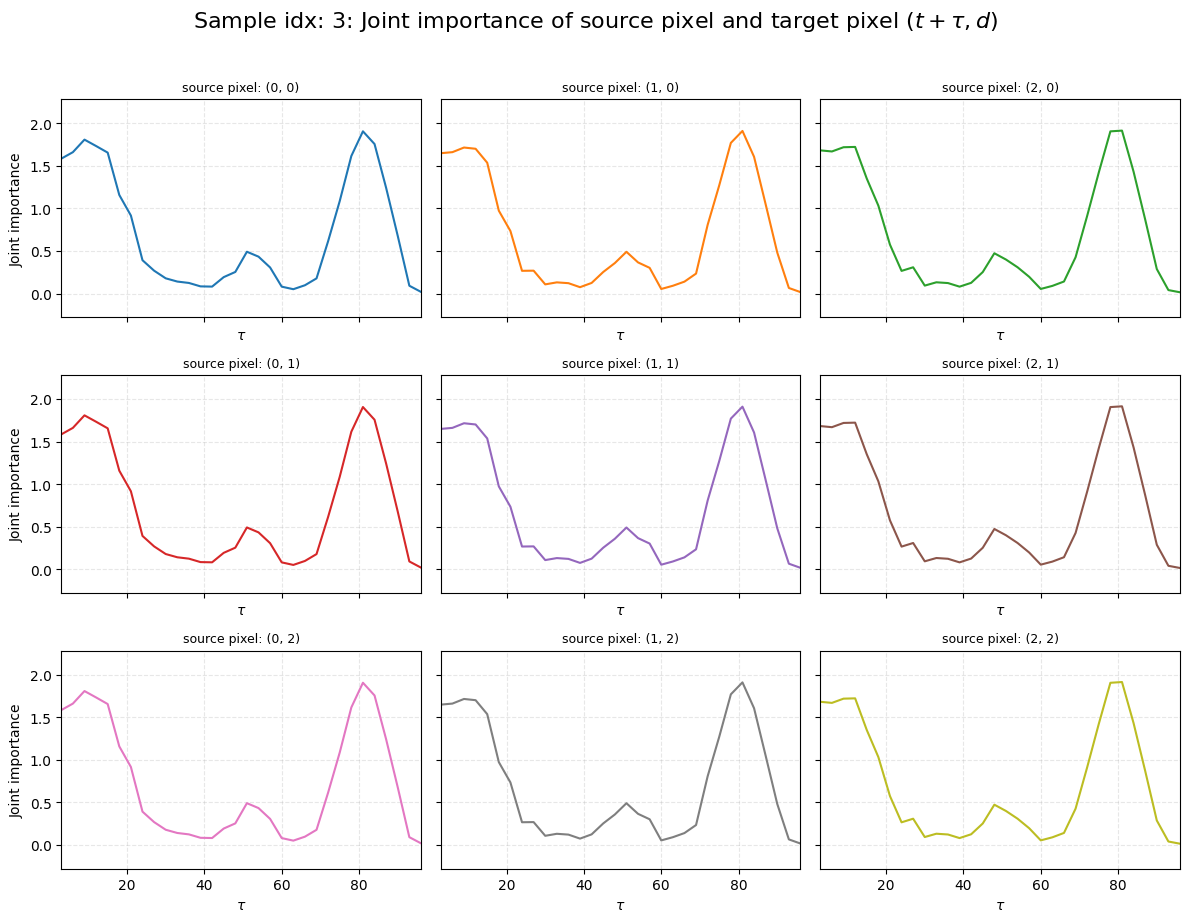

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: (T_, P_, B, W)
T_, P_, B, W = all_Ipq_flat_taus.shape
tau_vals = tau_values
src_pix  = source_pixels

sample_idx = 3

mu  = all_Ipq_flat_taus[:,:,sample_idx,:].mean(axis=2)   # (T_, P_)
sig = all_Ipq_flat_taus[:,:,sample_idx,:].std(axis=2)    # (T_, P_)


# mu  = all_Ipq_flat_taus.mean(axis=(2, 3))   # (T_, P_)
# sig = all_Ipq_flat_taus.std(axis=(2, 3))    # (T_, P_)

# 2) global y-lims
ymin = (mu - sig).min()
ymax = (mu + sig).max()

# 3) subplot grid
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                         sharex=True, sharey=True)
axes = axes.ravel()
cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax   = axes[j]
    color = cmap(j % cmap.N)
    m_j  = mu[:, j]
    s_j  = sig[:, j]

    ax.plot(tau_vals, m_j, color=color, linewidth=1.5)
    # ax.fill_between(tau_vals, m_j - s_j, m_j + s_j, color=color, alpha=0.2)

    ax.set_title(f"source pixel: {src_pix[j]}", fontsize=9)
    ax.set_xlim(min(tau_vals), max(tau_vals))
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3, linestyle='--')

    # if ax.get_subplotspec().is_last_row():
    ax.set_xlabel(r"$\tau$", fontsize=10)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Joint importance", fontsize=10)

# remove extras
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])
fig.suptitle(fr"Sample idx: {sample_idx}: Joint importance of source pixel and target pixel $(t+\tau, d)$",
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### Joint importance: aggregate over W and B

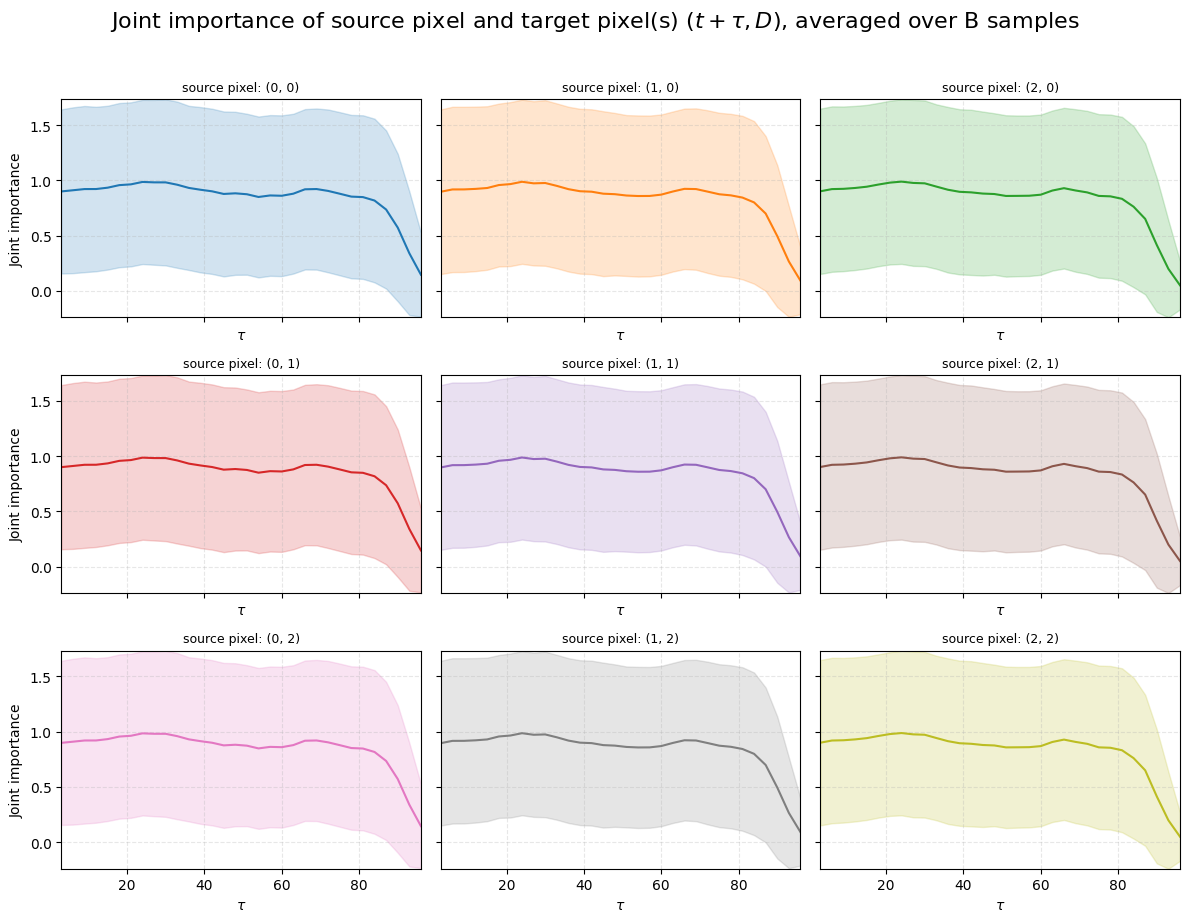

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm

# all_Ipq_flat_taus: (T_, P_, B, W)
T_, P_, B, W = all_Ipq_flat_taus.shape
tau_vals = tau_values
src_pix  = source_pixels


mu  = all_Ipq_flat_taus.mean(axis=(2, 3))   # (T_, P_)
sig = all_Ipq_flat_taus.std(axis=(2, 3))    # (T_, P_)

# 2) global y-lims
ymin = (mu - sig).min()
ymax = (mu + sig).max()

# 3) subplot grid
cols = int(math.ceil(math.sqrt(P_)))
rows = int(math.ceil(P_ / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows),
                         sharex=True, sharey=True)
axes = axes.ravel()
cmap = cm.get_cmap('tab10')

for j in range(P_):
    ax   = axes[j]
    color = cmap(j % cmap.N)
    m_j  = mu[:, j]
    s_j  = sig[:, j]

    ax.plot(tau_vals, m_j, color=color, linewidth=1.5)
    ax.fill_between(tau_vals, m_j - s_j, m_j + s_j, color=color, alpha=0.2)

    ax.set_title(f"source pixel: {src_pix[j]}", fontsize=9)
    ax.set_xlim(min(tau_vals), max(tau_vals))
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3, linestyle='--')

    # if ax.get_subplotspec().is_last_row():
    ax.set_xlabel(r"$\tau$", fontsize=10)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Joint importance", fontsize=10)

# remove extras
for k in range(P_, rows*cols):
    fig.delaxes(axes[k])
fig.suptitle(fr"Joint importance of source pixel and target pixel(s) $(t+\tau, D)$, averaged over B samples",
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### Single importance plotting

In [ ]:
all_Ip_flat_taus[:,:,0,0]

array([[0.27880406, 0.27880406, 0.27880406],
       [0.61878741, 0.61878741, 0.61878741],
       [0.02070177, 0.02070177, 0.02070177],
       [0.63484573, 0.63484573, 0.63484573],
       [0.63017762, 0.63017762, 0.63017762],
       [0.1048516 , 0.1048516 , 0.1048516 ],
       [0.36037076, 0.36037076, 0.36037076],
       [0.62797797, 0.62797797, 0.62797797],
       [0.55448973, 0.55448973, 0.55448973],
       [1.14018822, 1.14018822, 1.14018822],
       [0.83129418, 0.83129418, 0.83129418],
       [0.9042784 , 0.9042784 , 0.9042784 ],
       [1.3569634 , 1.3569634 , 1.3569634 ],
       [0.62195361, 0.62195361, 0.62195361],
       [1.35938382, 1.35938382, 1.35938382],
       [0.76518095, 0.76518095, 0.76518095],
       [1.34752929, 1.34752929, 1.34752929],
       [1.35903621, 1.35903621, 1.35903621],
       [1.35980713, 1.35980713, 1.35980713],
       [1.31806171, 1.31806171, 1.31806171],
       [0.30804658, 0.30804658, 0.30804658],
       [1.2011168 , 1.2011168 , 1.2011168 ],
       [1.

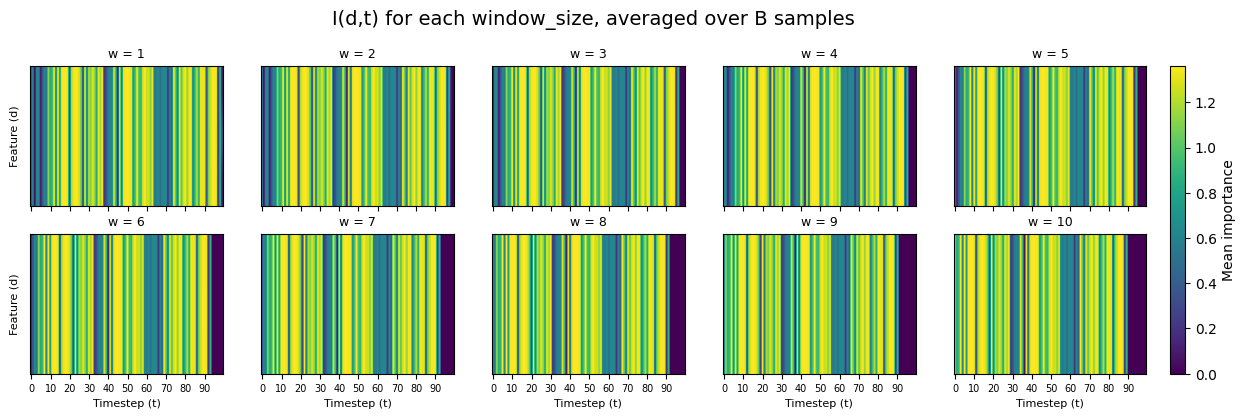

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import math

# all_Ip_flat_taus: (T, D, B, W)
T, D, B, W = all_Ip_flat_taus.shape

# 1) mean over batch only, keep W
mean_w = all_Ip_flat_taus[:,:,0,:]   # (T, D, W)
# mean_w = np.mean(all_Ip_flat_taus, axis=2)   # (T, D, W)

# 2) global color scale across all windows
vmin, vmax = np.nanmin(mean_w), np.nanmax(mean_w)

# 3) subplot grid (e.g. 5x2 if W=10)
cols = 5
rows = math.ceil(W / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2), sharex=True, sharey=True)
axes = axes.ravel()

for w in range(W):
    ax = axes[w]
    # transpose so features on y-axis (3 strips), time/tau on x-axis
    heat = mean_w[:, :, w].T  # (D, T)

    im = ax.imshow(
        heat,
        origin='lower',
        aspect='auto',
        cmap='viridis',
        # interpolation='nearest',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(f"w = {w+1}", fontsize=9)
    ax.set_yticks(range(D))
    ax.set_yticklabels([f"d={i}" for i in range(D)], fontsize=7)
    if w >= (W - cols):  # last row
        ax.set_xticks(np.arange(0, T, 10))
        ax.set_xticklabels(np.arange(0, T, 10), fontsize=7)
        ax.set_xlabel("Timestep (t)", fontsize=8)
    else:
        ax.set_xticks([])

    if w % cols == 0:
        ax.set_ylabel("Feature (d)", fontsize=8)
    else:
        ax.set_yticks([])

# remove unused axes
for k in range(W, rows*cols):
    fig.delaxes(axes[k])

# single shared colorbar
cbar = fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Mean importance", fontsize=10)

fig.suptitle("I(d,t) for each window_size, averaged over B samples", fontsize=14, y=1.02)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


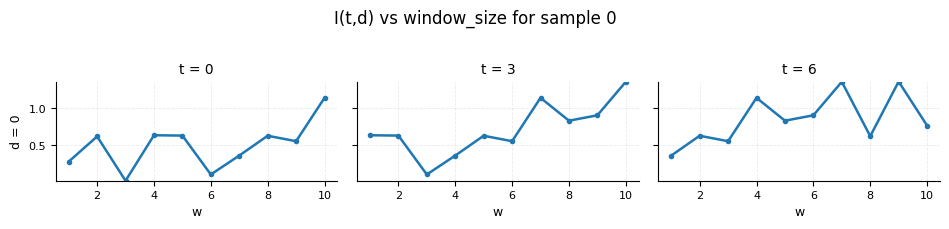

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_I_vs_w_grid(all_Ip_flat_taus, t_sel, d_sel, sample_id=0, title=None):
    """
    all_Ip_flat_taus: np.ndarray [T, D, B, W]
    t_sel, d_sel    : lists of indices to show
    sample_id       : which example in the batch
    """
    T, D, B, W = all_Ip_flat_taus.shape
    w_axis = np.arange(1, W+1)

    # collect values to get common y-lims
    vals = [all_Ip_flat_taus[t, d, sample_id, :] for d in d_sel for t in t_sel]
    ymin = np.nanmin([v.min() for v in vals])
    ymax = np.nanmax([v.max() for v in vals])

    nrows, ncols = len(d_sel), len(t_sel)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(ncols*3.2, nrows*2.2),
        sharex=True, sharey=True,
        constrained_layout=True
    )

    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes[np.newaxis, :]
    elif ncols == 1:
        axes = axes[:, np.newaxis]

    cmap = cm.get_cmap("tab10")
    for r, d_idx in enumerate(d_sel):
        color = cmap(r % cmap.N)  # same color per row (fixed d)
        for c, t_idx in enumerate(t_sel):
            ax = axes[r, c]
            y = all_Ip_flat_taus[t_idx, d_idx, sample_id, :]

            ax.plot(w_axis, y, lw=1.8, marker='o', ms=3, color=color)
            ax.set_ylim(ymin, ymax)
            ax.grid(alpha=0.25, linestyle='--', linewidth=0.6)

            # tidy spines
            for spine in ("top", "right"):
                ax.spines[spine].set_visible(False)

            # titles/labels
            if r == 0:
                ax.set_title(f"t = {t_idx}", fontsize=10, pad=6)
            if c == 0:
                ax.set_ylabel(f"d = {d_idx}", fontsize=9)

            if r == nrows - 1:
                ax.set_xlabel("w", fontsize=9)

            # lighter tick labels
            ax.tick_params(labelsize=8)

    if title is None:
        title = f"I(t,d) vs window_size for sample {sample_id}"
    fig.suptitle(title, fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

# --- call it ---
t_sel = [0, 3, 6]
d_sel = [0]
plot_I_vs_w_grid(all_Ip_flat_taus, t_sel, d_sel, sample_id=0)


### Raw importance from old attribution method

In [95]:
# 1) Prepare your explainer and data
device = 'cuda'
explainer = OGWinITExplainer(
                    device,
                    dataset.feature_size,
                    dataset.get_name(),
                    path= ckpt_path / dataset.get_name() / str(cv),
                    train_loader=dataset.train_loaders[cv],  # for CF generaton if required, NOT for training 
                    other_args = xplainer_params
                )   

explainer.set_model(model,
                    set_eval=True)

B, D, T = X_test.shape

imp_score_old = explainer.attribute(torch.unsqueeze(X_test[0], 0), all_zero_cf= True)
imp_score_old.shape # B, D, T, W

kwargs is not empty. Unused kwargs={'other_args': {'mask_strategy': 'upper_triangular', 'height': 3}}


(1, 3, 100, 10)

In [99]:

heat = imp_score_old[0,:,:,0]
heat

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.23626804e-05, -1.39643438e-04,
         1.08033419e-07,  4.03309241e-06, -1.40149496e-06,
         1.83194876e-04,  7.14173075e-06,  8.53906386e-07,
        -5.47996024e-07, -3.65264714e-05, -1.38282776e-04,
         6.60767546e-05,  3.00694956e-06,  2.82551628e-06,
         1.81252835e-06,  5.28097153e-05, -3.46293033e-04,
         5.32746315e-04, -2.75834464e-06,  5.15580177e-06,
         5.60097396e-05, -4.22000885e-05, -1.59752381e-06,
        -8.07046890e-05,  1.78426504e-04,  3.45893204e-06,
        -1.04665756e-04, -1.09774992e-05, -6.69877045e-04,
        -1.29540684e-04,  1.74045563e-05,  2.38418579e-07,
         1.60932541e-05,  2.76316423e-05, -3.88026237e-04,
        -5.28097153e-05, -1.38480682e-05,  1.56015158e-04,
        -6.58072531e-06,  6.05359674e-07,  7.07106665e-0

(3, 100)
(3, 100)
(3, 100)
(3, 100)
(3, 100)
(3, 100)
(3, 100)
(3, 100)
(3, 100)
(3, 100)


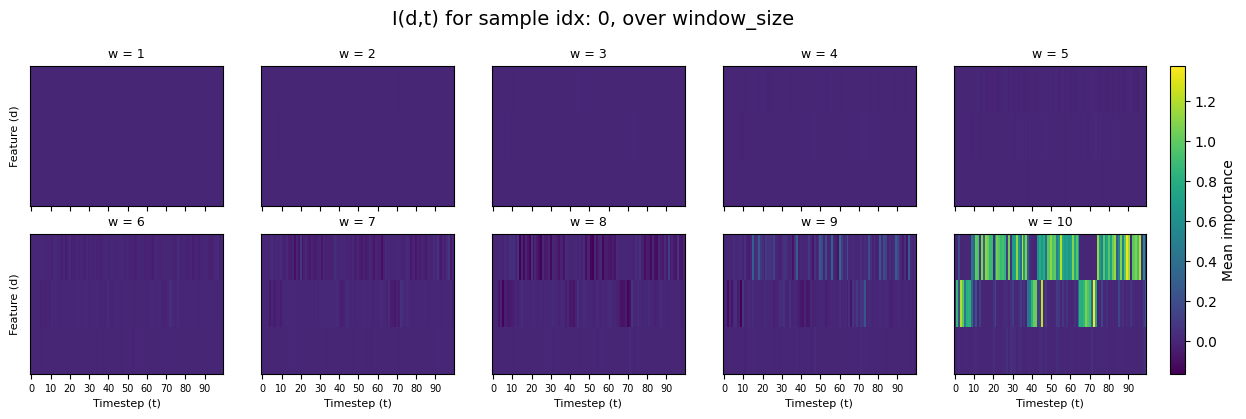

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import math


B, D, T, W = imp_score_old.shape


mean_w = imp_score_old[0,:,:,:]   
# mean_w = np.mean(imp_score_old, axis=0)   # (T, D, W)

# 2) global color scale across all windows
vmin, vmax = np.nanmin(mean_w), np.nanmax(mean_w)

# 3) subplot grid (e.g. 5x2 if W=10)
cols = 5
rows = math.ceil(W / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2), sharex=True, sharey=True)
axes = axes.ravel()

for w in range(W):
    ax = axes[w]
    # transpose so features on y-axis (3 strips), time/tau on x-axis
    heat = mean_w[:, :, w]  # (D, T)
    print(heat.shape)
    im = ax.imshow(
        heat,
        origin='lower',
        aspect='auto',
        cmap='viridis',
        interpolation='nearest',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(f"w = {w+1}", fontsize=9)
    ax.set_yticks(range(D))
    ax.set_yticklabels([f"d={i}" for i in range(D)], fontsize=7)
    if w >= (W - cols):  # last row
        ax.set_xticks(np.arange(0, T, 10))
        ax.set_xticklabels(np.arange(0, T, 10), fontsize=7)
        ax.set_xlabel("Timestep (t)", fontsize=8)
    else:
        ax.set_xticks([])

    if w % cols == 0:
        ax.set_ylabel("Feature (d)", fontsize=8)
    else:
        ax.set_yticks([])

# remove unused axes
for k in range(W, rows*cols):
    fig.delaxes(axes[k])

# single shared colorbar
cbar = fig.colorbar(im, ax=axes.tolist(), fraction=0.02, pad=0.02)
cbar.set_label("Mean importance", fontsize=10)

fig.suptitle("I(d,t) for sample idx: 0, over window_size", fontsize=14, y=1.02)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [108]:
X_test[0].shape

torch.Size([3, 100])

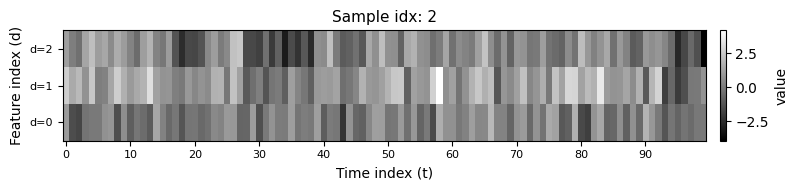

In [123]:
import torch, numpy as np
import matplotlib.pyplot as plt

# x_sample: torch.Size([D=3, T=100])
sample_idx = 2
x_sample = X_test[sample_idx].detach().cpu().numpy()   # (3,100)

# optional: normalize per-feature for nicer contrast
# x_norm = (x_sample - x_sample.min(axis=1, keepdims=True)) / \
#          (x_sample.ptp(axis=1, keepdims=True) + 1e-8)
x_norm = x_sample  # or use the normalized version above

plt.figure(figsize=(8, 2))  # same wide & short look
im = plt.imshow(
    x_norm,
    origin='lower',
    aspect='auto',
    cmap='gray',         # black/grey/white
    interpolation='nearest'
)
cbar = plt.colorbar(im, fraction=0.04, pad=0.02)
cbar.set_label("value", fontsize=10)

T = x_norm.shape[1]
plt.xticks(np.arange(0, T, 10), np.arange(0, T, 10), fontsize=8)
plt.yticks([0,1,2], ["d=0","d=1","d=2"], fontsize=8)

plt.xlabel("Time index (t)", fontsize=10)
plt.ylabel("Feature index (d)", fontsize=10)
plt.title(rf"Sample idx: {sample_idx}", fontsize=11)
plt.tight_layout()
plt.show()


#### Correlation 

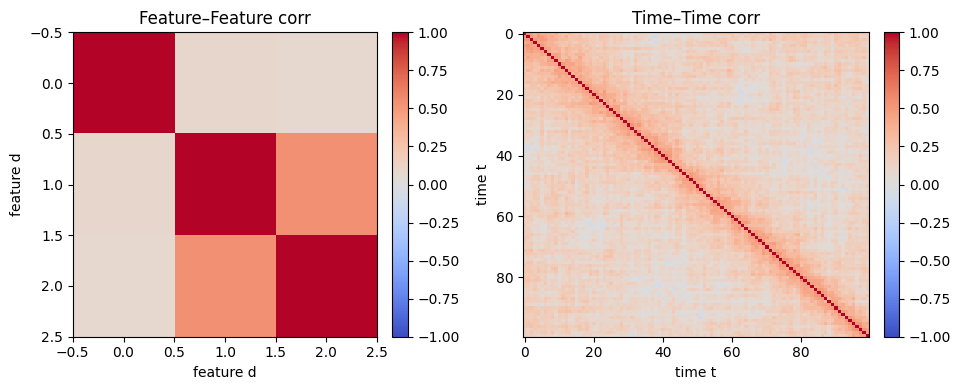

In [129]:
import torch, numpy as np
import matplotlib.pyplot as plt

# assume X_test is torch.Tensor [B, D, T]
X = X_test.detach().cpu().numpy()
B, D, T = X.shape

# ---- 1) Feature–feature correlation (collapse batch & time) ----
# reshape to D × (B*T)
feat_mat = X.transpose(1, 0, 2).reshape(D, -1)          # each row = one feature
corr_feat = np.corrcoef(feat_mat)                       # (D, D)

# ---- 2) Time–time correlation (collapse batch & features) ----
time_mat = X.transpose(2, 0, 1).reshape(T, -1)          # each row = one time index
corr_time = np.corrcoef(time_mat)                       # (T, T)

# ---- 3) (Optional) Full pixel–pixel corr (DT × DT) -> heavy, beware memory ----
# pix_mat = X.reshape(B, D*T).transpose(1, 0)            # (DT, B)
# corr_pix = np.corrcoef(pix_mat)

# ---- 4) Plot the two common ones ----
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im0 = axes[0].imshow(corr_feat, vmin=-1, vmax=1, cmap='coolwarm')
axes[0].set_title("Feature–Feature corr")
axes[0].set_xlabel("feature d")
axes[0].set_ylabel("feature d")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(corr_time, vmin=-1, vmax=1, cmap='coolwarm', aspect='auto')
axes[1].set_title("Time–Time corr")
axes[1].set_xlabel("time t")
axes[1].set_ylabel("time t")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


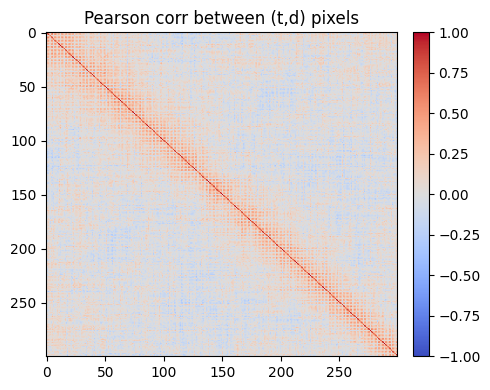

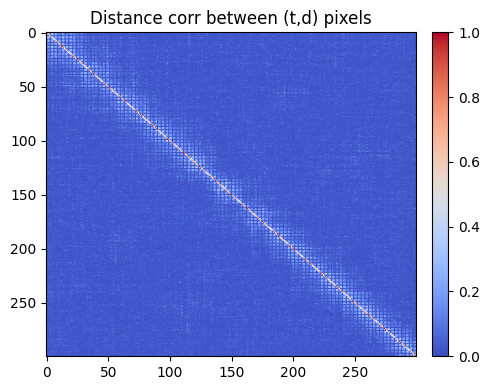

/tmp/ipykernel_217532/1081248502.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


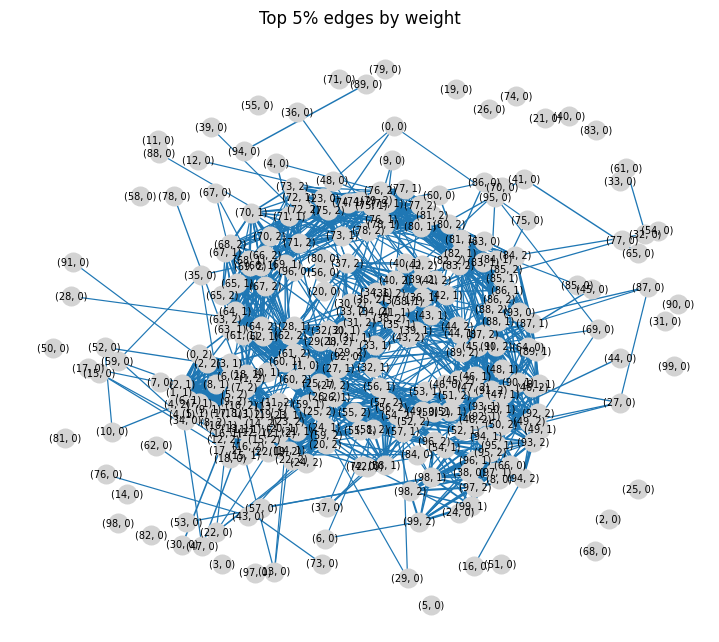

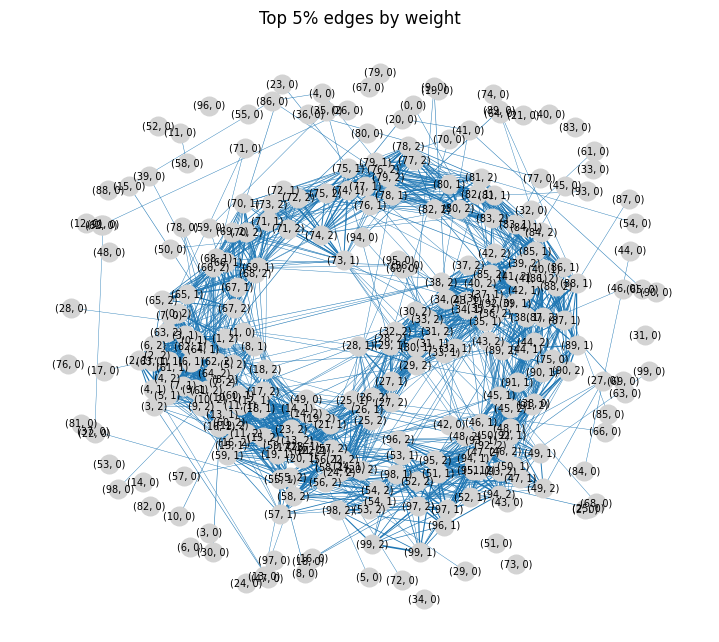

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product

# -------------------------------------------------
# 1. Prep: flatten B,D,T -> node matrix (N_nodes x N_samples)
# -------------------------------------------------
def pixel_matrix(X):  # X: (B, D, T) torch or np
    if hasattr(X, "detach"):
        X = X.detach().cpu().numpy()
    B, D, T = X.shape
    pixels = [(t,d) for t in range(T) for d in range(D)]  # order (t-fast)
    mat = X.transpose(2,1,0).reshape(T*D, B)              # (N_nodes, B)
    return mat, pixels, (T, D)

# -------------------------------------------------
# 2. Pearson adjacency
# -------------------------------------------------
def pearson_adj(mat):
    return np.corrcoef(mat)

# -------------------------------------------------
# 3. Distance correlation adjacency (vectorized-ish)
#    O(N_nodes^2 * N_samples^2): OK for small N_nodes
# -------------------------------------------------
def distance_corr_matrix(mat, eps=1e-12):
    N, n = mat.shape  # N nodes, n samples
    # Precompute pairwise centered distance matrices per node
    # For speed/memory, do loops; optimize later if needed.
    def dcov2(x, y):
        # x,y shape (n,)
        A = np.abs(x[:,None] - x[None,:])
        B = np.abs(y[:,None] - y[None,:])
        A -= A.mean(axis=0, keepdims=True)
        A -= A.mean(axis=1, keepdims=True)
        A += A.mean()
        B -= B.mean(axis=0, keepdims=True)
        B -= B.mean(axis=1, keepdims=True)
        B += B.mean()
        return (A*B).mean()

    dvar = np.empty(N, dtype=np.float64)
    for i in range(N):
        dvar[i] = dcov2(mat[i], mat[i]) + eps

    adj = np.empty((N, N), dtype=np.float64)
    for i in range(N):
        adj[i, i] = 1.0
        for j in range(i+1, N):
            dc = dcov2(mat[i], mat[j])
            val = dc / np.sqrt(dvar[i]*dvar[j])
            adj[i, j] = adj[j, i] = val
    return adj

# -------------------------------------------------
# 4. Heatmap + graph utility
# -------------------------------------------------
def plot_heatmap(A, title, vmin=-1, vmax=1):
    plt.figure(figsize=(5,4))
    im = plt.imshow(A, cmap='coolwarm', vmin=vmin, vmax=vmax, aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_graph(A, pixels, top_percent=95):
    # threshold
    vals = A[np.triu_indices_from(A, 1)]
    thr  = np.percentile(vals, top_percent)
    mask = (A >= thr)
    np.fill_diagonal(mask, False)

    G = nx.Graph()
    # add nodes with labels (t,d)
    for i, p in enumerate(pixels):
        G.add_node(i, label=p)

    # add weighted edges
    inds = np.transpose(np.triu(mask, 1).nonzero())
    for i,j in inds:
        G.add_edge(i, j, weight=A[i,j])

    # relabel for display
    mapping = {i: G.nodes[i]['label'] for i in G.nodes}
    G = nx.relabel_nodes(G, mapping)

    plt.figure(figsize=(7,6))
    pos = nx.spring_layout(G, seed=42, k=0.25)
    widths = [G[u][v]['weight']*3 for u,v in G.edges]
    nx.draw(G, pos,
            node_size=180, node_color='lightgray',
            edge_color='tab:blue', width=widths,
            with_labels=True, font_size=7)
    plt.title(f"Top {100-top_percent}% edges by weight")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 5. Run on your X_test
# -------------------------------------------------
# Example usage
mat, pixels, (T,D) = pixel_matrix(X_test)   # X_test: (B,D,T)
pear_adj = pearson_adj(mat)                 # (N,N)
dcor_adj = distance_corr_matrix(mat)        # (N,N)

# plot
plot_heatmap(pear_adj, "Pearson corr between (t,d) pixels", vmin=-1, vmax=1)
plot_heatmap(dcor_adj, "Distance corr between (t,d) pixels", vmin=0, vmax=1)

# graph (choose one)
plot_graph(np.abs(pear_adj), pixels, top_percent=95)
plot_graph(dcor_adj, pixels, top_percent=95)


## Old code

In [ ]:
# For illustration, unpack shapes:


# 1) compute mean & std over the B axis
delta_mean_batch = delta.mean(axis=2)  # shape (n, n)
delta_std_batch  = delta.std(axis=2)   # shape (n, n)

# 2) build pair labels and flattened arrays of means/stds
pair_labels = []
mean_vals   = []
std_vals    = []
for i in range(n):
    for j in range(i+1, n):
        pair_labels.append(f"{all_pixels[i]}→{all_pixels[j]}")
        mean_vals.append(delta_mean_batch[i, j])
        std_vals.append(delta_std_batch[i, j])
mean_vals = np.array(mean_vals)
std_vals  = np.array(std_vals)



# 5) plot skewed histogram (log scale)
plt.figure(figsize=(6, 4))
plt.hist(delta.flatten(), bins=10, edgecolor='k', log=True)
plt.title("All ΔI values (log scale)")
plt.xlabel("ΔI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6) bar chart of mean ΔI ± std
plt.figure(figsize=(10, 4))
plt.bar(range(len(mean_vals)), mean_vals, yerr=std_vals, capsize=3)
plt.xticks(range(len(mean_vals)), pair_labels, rotation=90)
plt.title("Mean ΔI per Pixel-Pair ± 1 Std")
plt.ylabel("ΔI")
plt.tight_layout()
plt.show()

# 7) heatmap of the mean
heat = np.mean(delta, axis = 2)
plt.figure(figsize=(6, 6))
im = plt.imshow(heat, cmap='hot', aspect='auto')
plt.colorbar(im, label='ΔI')
plt.title(f"Interaction Heatmap)")
plt.xticks(np.arange(n), [str(p) for p in all_pixels], rotation=90)
plt.yticks(np.arange(n), [str(p) for p in all_pixels])
plt.tight_layout()
plt.show()


        
        # print(len(tau_values), len(values))
        # print(values)
        # plt.plot(tau_values, values, marker='o', label=strategy)

    
    # plt.title(f"Mean ΔI vs τ ({strategy})")
    # plt.xlabel("τ")
    # plt.ylabel("Mean ΔI")
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

# 9) illustrate an example pair
# example_pair = pair_sampling_strategy(pixels, T, D, tau=1, strategy="same_d")[0]
# illustrate_pair(example_pair, T, D)


In [ ]:
delta.shape